# Klasyfikacja obiektów kosmicznych - Modelowanie
#### 0. Dane 
#### 0.1. Pakiety


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# scaling
from sklearn.preprocessing import MinMaxScaler

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# svm
from sklearn.svm import SVC

# decision tree
from sklearn.tree import DecisionTreeClassifier

#### 0.2. Podział na zbiór treningowy i testowy

In [9]:
# wczytanie danych
df = pd.read_csv('./data/development_data.csv')

# podział danych na zbiór treningowy i testowy
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# reset indeksów
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# kolumny z waznymi cechami
imp_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'spec_obj_ID', 'redshift']

# X - ramka danych ograniczona do interesujących nas cech
X = train_df[imp_cols]
y = train_df['class'].values

X_test = test_df[imp_cols]
y_test = test_df['class'].values

### 0.3. Normalizacja

In [10]:
scaling = MinMaxScaler()
X = scaling.fit_transform(X)
X_test = scaling.transform(X_test)

## 1. Feature importance 
 Feature importance raz jeszcze.
Wykorzystamy, oprócz Random Forest Classifier, Gini i AUC.
### 1.1. Random Forest Classifier

In [ ]:
X = pd.DataFrame(X, columns=imp_cols)

# copy X for testing purposes
X_ = X.copy()

# add new features
X_['u-g'] = X_['u'] - X_['g']
X_['g-r'] = X_['g'] - X_['r']
X_['r-i'] = X_['r'] - X_['i']
X_['i-z'] = X_['i'] - X_['z']
X_['u-r'] = X_['u'] - X_['r']
X_['ug_mr'] = np.log(X_['u'] / X_['g'])
X_['ri_mr'] = np.log(X_['r'] / X_['i'])
X_['iz_mr'] = np.log(X_['i'] / X_['z'])
X_['rs*alpha'] = X_['redshift'] * X_['alpha']
X_['rs*delta'] = X_['redshift'] * X_['delta']
X_['rs*z'] = X_['redshift'] * X_['z']
X_['rs*u'] = X_['redshift'] * X_['u']
X_['rs*i'] = X_['redshift'] * X_['i']
X_['rs*g'] = X_['redshift'] * X_['g']
X_['rs*r'] = X_['redshift'] * X_['r']

# add new features to the list of important columns
imp_cols_ = imp_cols + ['u-g', 'g-r', 'r-i', 'i-z', 'u-r', 'ug_mr', 'ri_mr', 'iz_mr', 'rs*alpha', 'rs*delta', 'rs*z', 'rs*u', 'rs*i', 'rs*g', 'rs*r']

# change NaNs to median value --- there is only one NaN in each column
median_ug_mr = X_['ug_mr'].median()
X_['ug_mr'] = X_['ug_mr'].fillna(median_ug_mr)

median_r_i = X_['ri_mr'].median()
X_['ri_mr'] = X_['ri_mr'].fillna(median_r_i)

median_iz_mr = X_['iz_mr'].median()
X_['iz_mr'] = X_['iz_mr'].fillna(median_iz_mr)


Feature ranking:
1. Feature redshift (0.19182345174644133)
2. Feature rs*i (0.16484819304435055)
3. Feature rs*z (0.1461277790003896)
4. Feature rs*r (0.08126056899826901)
5. Feature rs*g (0.07631252763364525)
6. Feature rs*u (0.06510610793399438)
7. Feature rs*delta (0.06161750929598804)
8. Feature ri_mr (0.053774118204229004)
9. Feature rs*alpha (0.04455121516600511)
10. Feature g-r (0.027496450255646905)
11. Feature u-r (0.02029475607278812)
12. Feature iz_mr (0.01759030297097116)
13. Feature g (0.007951781173826859)
14. Feature i-z (0.006947134137987214)
15. Feature z (0.0065293526944527865)
16. Feature r-i (0.005829339514861743)
17. Feature ug_mr (0.005163994008668258)
18. Feature r (0.0050727331584986025)
19. Feature u (0.0039373625952613765)
20. Feature u-g (0.003861523561666794)
21. Feature i (0.002052357923539533)
22. Feature spec_obj_ID (0.0014222424349871034)
23. Feature alpha (0.0003818386774909142)
24. Feature delta (4.735979604045256e-05)


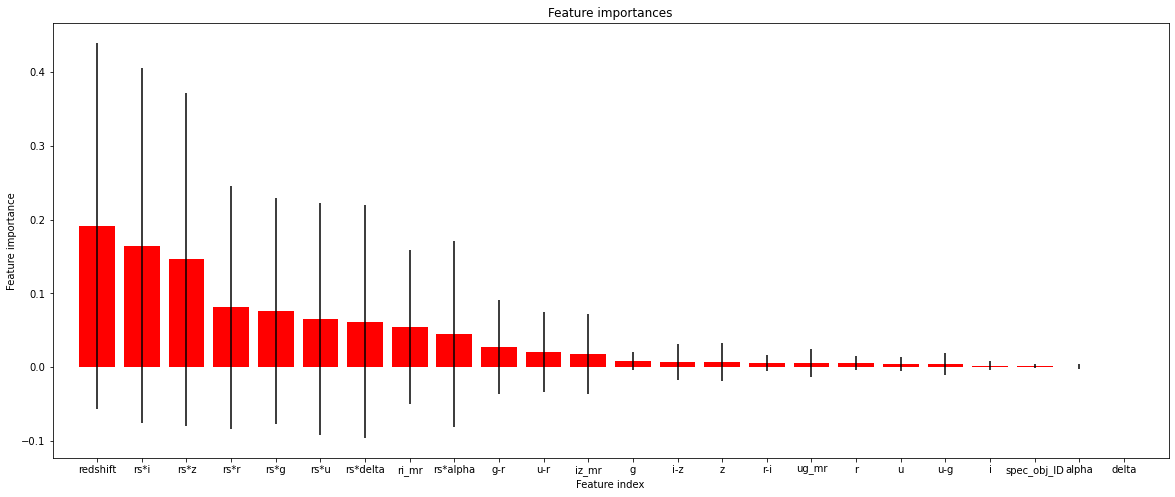

In [15]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()

### 1.2. Gini

Feature ranking:
1. Feature redshift (0.8526843444248675)
2. Feature g-r (0.04782270055904909)
3. Feature r (0.01537482974916319)
4. Feature g (0.014067672858430655)
5. Feature spec_obj_ID (0.007874515721757357)
6. Feature rs*u (0.006172041578492182)
7. Feature u-r (0.004882517021777542)
8. Feature ri_mr (0.00466509458360853)
9. Feature r-i (0.004662129640473268)
10. Feature rs*delta (0.00456628286359744)
11. Feature delta (0.003550146383922064)
12. Feature alpha (0.0030791344827774923)
13. Feature rs*alpha (0.0030614877831820963)
14. Feature i (0.0030037861476134874)
15. Feature rs*g (0.002885190943869501)
16. Feature i-z (0.002812493490513458)
17. Feature iz_mr (0.0027460109261826155)
18. Feature rs*z (0.0026735631588277135)
19. Feature ug_mr (0.0026501248423539095)
20. Feature u-g (0.002458722100276676)
21. Feature z (0.002432283160489405)
22. Feature rs*r (0.002295084797056416)
23. Feature u (0.0021738162082115603)
24. Feature rs*i (0.001406026573506784)


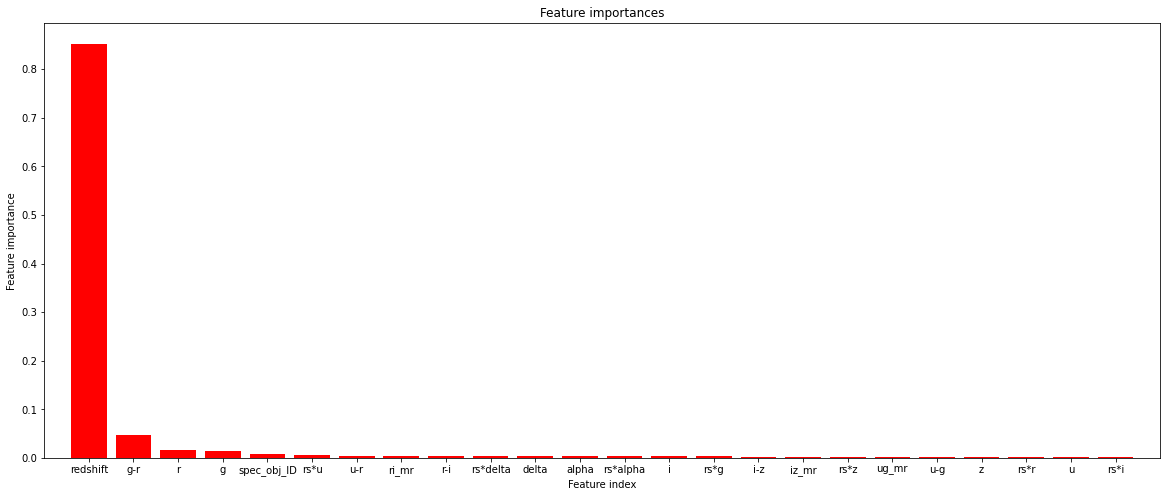

In [14]:
# train gini
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# print feature ranking and name the features
print("Feature ranking:")
for f in range(X_.shape[1]):
    print(f"{f + 1}. Feature {imp_cols_[indices[f]]} ({feature_importances[indices[f]]})")

# plot feature importances
plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(X_.shape[1]), feature_importances[indices], color="r", align="center")
plt.xticks(range(X_.shape[1]), [imp_cols_[i] for i in indices])
plt.xlim([-1, X_.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()

Według modelu Gini, cechami posiadającymi współczynnik ważności >= 5% są:
- redshift,
- g-r.

### 1.3. AUC

In [ ]:
# train auc
clf = DecisionTreeClassifier(criterion='entropy')

## 2. Predykcyjność kolumn

## 3. Modelowanie
Modele będziemy badać na danych treningowych, a następnie na testowych. Ostatecznie wybierzemy najlepszy.

## 4. Wybrany model